In [1]:
import numpy as np
import scipy as sp
import torch
import torch.nn as nn
import time
import copy
import pickle
import matplotlib
import matplotlib.pyplot as plt
import networkx as nx
import os
import sys
import math
import random

import torch_geometric as tg
import itertools
from torch_geometric.data import Data
from torch_geometric.nn import GATConv, GCNConv, GATv2Conv
from torch_geometric.utils import add_self_loops, remove_self_loops, softmax, get_laplacian, to_dense_adj
from my_gat import my_GATConv
from my_mlp_gat import GATv3Layer
sys.path.insert(0, os.path.abspath('../../'))
from torch_geometric.datasets import Planetoid

import torch.nn.functional as F # <-- Remove

In [2]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [3]:
class Model_GCN(torch.nn.Module):
    def __init__(self, d, out_d):
        super(Model_GCN, self).__init__()
        
        self.conv1 = GCNConv(d,out_d, bias=False)

    def forward(self, data):
        x = data.x
        x = self.conv1(x, data.edge_index)
        
        return x.squeeze(-1)
    
class Model_linear(torch.nn.Module):
    def __init__(self, d, out_d):
        super(Model_linear, self).__init__()
        
        self.linear = torch.nn.Linear(d,out_d, bias=False)

    def forward(self, data):
        x = data.x
        x = self.linear(x)
        
        return x.squeeze(-1)

In [4]:
class Eigen2(nn.Module):
    def __init__(self, k):
        super().__init__()
        self.k = k
        
    def forward(self, edge_idx, n, sigma):
        # lap_idx, lap_wt = get_laplacian(edge_idx, normalization="sym")
        edge_adj = to_dense_adj(edge_idx)
        eigenvals, eigenvecs = torch.linalg.eig(edge_adj)
        top_eig = eigenvecs.squeeze(0)[:, 1:self.k+1]
        top_eig = torch.real(top_eig)
        
        new_edge_features = torch.Tensor(edge_idx.size(1), 1).to(edge_idx.device)
        new_edge_idx = edge_idx.T
        
        for idx, pair in enumerate(new_edge_idx):
            i, j = pair
            x_i_prime = top_eig[i]
            x_j_prime = top_eig[j]
            dot = torch.dot(x_i_prime, x_j_prime)
            final = 8 * torch.sqrt(torch.log(torch.tensor(n))) * sigma * torch.sign(dot)
            new_edge_features[idx] = final
            
        return new_edge_features.view(-1, 1), eigenvals, top_eig

class Model_GATv3(torch.nn.Module):
    def __init__(self, d, out_d):
        super(Model_GATv3, self).__init__()
        
        self.eigen = Eigen2(1)
        self.conv1 = GATv3Layer(
            in_channels=d, 
            out_channels=out_d,
            att_in_channels=2,
            att_out_channels=4,
            share_weights=True, 
            bias=False
        )

    def forward(self, data, mu):
        x = data.x
        # e = data.edge_index
        # y = data.y
        n = x.size(0)

        # p, q = get_graph_stats(e, y)
        sigma = torch.std(x)

        eigen_x, _, _ = self.eigen(data.edge_index, n=n, sigma=sigma)
        x, attn_weights, pair_pred = self.conv1(x, data.edge_index, edge_attr=eigen_x, cur_mu=mu, sigma=sigma, return_attention_info=True)
        
        return x.squeeze(-1), attn_weights, pair_pred

In [5]:
@torch.no_grad()
def measure_accuracy(model, data):
    model.eval()
         
    logits = model(data) # forward operation
    preds = torch.sigmoid(logits) > 0.5
    
    # calculate training accuracy
    correct = preds[data.train_mask] == data.ynew[data.train_mask]
    train_acc = int(correct.sum()) / int(data.train_mask.sum())
    
    # calculate training accuracy
    correct = preds[data.test_mask] == data.ynew[data.test_mask]
    test_acc = int(correct.sum()) / int(data.test_mask.sum())
        
    return train_acc, test_acc

@torch.no_grad()
def measure_accuracy_gat(model, data, mu):
    model.eval()
         
    logits, attn_weights, pair_pred = model(data, mu) # forward operation
    preds = torch.sigmoid(logits) > 0.5
    
    # calculate training accuracy
    correct = preds[data.train_mask] == data.ynew[data.train_mask]
    train_acc = int(correct.sum()) / int(data.train_mask.sum())
    
    # calculate training accuracy
    correct = preds[data.test_mask] == data.ynew[data.test_mask]
    test_acc = int(correct.sum()) / int(data.test_mask.sum())
        
    return train_acc, test_acc, attn_weights, pair_pred

In [6]:
def find_nearest(array, value):
    array = np.asarray(array)
    idx = (np.abs(array - value)).argmin()
    return idx

def info_mlp_gat(attn_weights, idx, head):
    intra_weight = []
    idx_intra = []
    inter_weight = []
    idx_inter = []

    weights = attn_weights[1] # get gamma values

    idx_class0 = idx.nonzero(as_tuple=True)[0]
    idx_class1 = (~idx).nonzero(as_tuple=True)[0]
    for i in range(attn_weights[0].shape[1]):
        edge = [attn_weights[0][0][i].item(),attn_weights[0][1][i].item()]
        if ((edge[0] in idx_class0) and (edge[1] in idx_class0)) or ((edge[0] in idx_class1) and (edge[1] in idx_class1)):
            intra_weight.append(weights[i].item())
            idx_intra.append(i)
        else:
            inter_weight.append(weights[i].item())
            idx_inter.append(i)
    return intra_weight, idx_intra, inter_weight, idx_inter

def info_mlp_gat_scores_phi(attn_weights, idx, head):
    idx_intra = []
    idx_inter = []
    
    intra_weight_00 = []
    intra_weight_11 = []
    
    inter_weight_01 = []
    inter_weight_10 = []

    weights = attn_weights[2] # get attention scores

    idx_class0 = idx.nonzero(as_tuple=True)[0]
    idx_class1 = (~idx).nonzero(as_tuple=True)[0]
    for i in range(attn_weights[0].shape[1]):
        edge = [attn_weights[0][0][i].item(),attn_weights[0][1][i].item()]
        if ((edge[0] in idx_class0) and (edge[1] in idx_class0)):
            intra_weight_00.append(weights[i].item())
            idx_intra.append(i)
        elif ((edge[0] in idx_class1) and (edge[1] in idx_class1)):
            intra_weight_11.append(weights[i].item())
            idx_intra.append(i)
        elif ((edge[0] in idx_class0) and (edge[1] in idx_class1)):
            inter_weight_01.append(weights[i].item())
            idx_inter.append(i)
        elif ((edge[0] in idx_class1) and (edge[1] in idx_class0)):
            inter_weight_10.append(weights[i].item())
            idx_inter.append(i)
            
    return intra_weight_00, intra_weight_11, idx_intra, inter_weight_01, inter_weight_10, idx_inter

def info_mlp_gat_scores_psi(attn_weights, idx, head):
    idx_intra = []
    idx_inter = []
    
    intra_weight_00 = []
    intra_weight_11 = []
    
    inter_weight_01 = []
    inter_weight_10 = []

    weights = attn_weights[3] # get attention scores

    idx_class0 = idx.nonzero(as_tuple=True)[0]
    idx_class1 = (~idx).nonzero(as_tuple=True)[0]
    for i in range(attn_weights[0].shape[1]):
        edge = [attn_weights[0][0][i].item(),attn_weights[0][1][i].item()]
        if ((edge[0] in idx_class0) and (edge[1] in idx_class0)):
            intra_weight_00.append(weights[i].item())
            idx_intra.append(i)
        elif ((edge[0] in idx_class1) and (edge[1] in idx_class1)):
            intra_weight_11.append(weights[i].item())
            idx_intra.append(i)
        elif ((edge[0] in idx_class0) and (edge[1] in idx_class1)):
            inter_weight_01.append(weights[i].item())
            idx_inter.append(i)
        elif ((edge[0] in idx_class1) and (edge[1] in idx_class0)):
            inter_weight_10.append(weights[i].item())
            idx_inter.append(i)
            
    return intra_weight_00, intra_weight_11, idx_intra, inter_weight_01, inter_weight_10, idx_inter

def pair_acc(n_edges, pair_pred, idx_intra, idx_inter, head):
    
    tmp = torch.zeros(n_edges).to(device)
    tmp[pair_pred[:,head].reshape(len(pair_pred)) > 0] = 1

    gt = torch.zeros(n_edges).to(device)
    gt[idx_intra] = 1

    acc_intra_edges = 1 - torch.sum(torch.abs(gt[idx_intra] - tmp[idx_intra]))/len(idx_intra)
    acc_inter_edges = 1 - torch.sum(torch.abs(gt[idx_inter] - tmp[idx_inter]))/len(idx_inter)
    print("Head: ", head, " acc intra edges: ", acc_intra_edges.item(), " acc inter edges: ", acc_inter_edges.item())
    
    return acc_intra_edges, acc_inter_edges

In [7]:
def my_plot(name, which_class, heads, mus, degree, intra_gamma, inter_gamma, intra_gamma_, inter_gamma_, 
            intra_gamma_std, inter_gamma_std, intra_gamma_std_, inter_gamma_std_, 
            test_acc_mlp_gat, test_acc_gat, test_acc_gcn, test_acc_lin, 
            acc_intra_edges_all, acc_inter_edges_all, acc_intra_edges_all_, acc_inter_edges_all_,
            phi_intra_attn_00, phi_intra_attn_11, phi_inter_attn_01, phi_inter_attn_10,
            phi_intra_attn_00_std, phi_intra_attn_11_std, phi_inter_attn_01_std, phi_inter_attn_10_std,
            psi_intra_attn_00, psi_intra_attn_11, psi_inter_attn_01, psi_inter_attn_10,
            psi_intra_attn_00_std, psi_intra_attn_11_std, psi_inter_attn_01_std, psi_inter_attn_10_std):
    
    mus = mus.cpu()
    
    fig = plt.figure(figsize=(11, 7), dpi=80)

    plt.plot(mus,intra_gamma, linewidth=2, linestyle='-', marker='*', markersize=9, label='Average $\gamma$, intra edges, MLP-GAT')
#     plt.fill_between(mus,np.asarray(intra_gamma)-np.asarray(intra_gamma_std),np.asarray(intra_gamma)+np.asarray(intra_gamma_std),alpha=0.4)

    plt.plot(mus,inter_gamma, linewidth=2, linestyle='-', marker='X', markersize=9, label='Average $\gamma$, inter edges, MLP-GAT')
#     plt.fill_between(mus,np.asarray(inter_gamma)-np.asarray(inter_gamma_std),np.asarray(inter_gamma)+np.asarray(inter_gamma_std),alpha=0.4)
    
    d_mean = (1+degree).mean().cpu()
#     inv_d_std = (1/(1+degree)).std().cpu()
    inv_degree_mean_vec = (1/d_mean)*np.ones(len(mus))
    
    plt.plot(mus,inv_degree_mean_vec, linewidth=2, linestyle='-', marker='o', markersize=9, color = 'black', label='Average $1/|N_i|$')
#     plt.fill_between(mus,inv_degree_mean_vec-inv_d_std,inv_degree_mean_vec+inv_d_std,alpha=0.4)

    plt.grid(linestyle='dashed')
    plt.legend(fontsize=20)
    plt.xscale('log')
    plt.tick_params(axis='x', labelsize=18)
    plt.tick_params(axis='y', labelsize=18)
    plt.xlabel('Distance between means', fontsize=20)
    plt.ylabel('$\gamma$ value', fontsize=20)
    plt.show()
    
    fig.savefig("sanity/gammas_MLPGAT_real_data_ansatz_"+name+"_class_"+str(which_class)+"_indicator.pdf", dpi=400, bbox_inches='tight')
    
    fig = plt.figure(figsize=(11, 7), dpi=80)

    plt.plot(mus,intra_gamma_std, linewidth=2, linestyle='-', marker='*', markersize=9, label='Stand. dev. $\gamma$, intra edges, MLP-GAT')

    plt.plot(mus,inter_gamma_std, linewidth=2, linestyle='-', marker='X', markersize=9, label='Stand. dev. $\gamma$, inter edges, MLP-GAT')
    
#     d_mean = (1+degree).mean().cpu()
    inv_d_std = (1/(1+degree)).std().cpu()
#     inv_degree_mean_vec = (1/d_mean)*np.ones(len(mus))
    
    plt.plot(mus,inv_d_std*np.ones(len(mus)), linewidth=2, linestyle='-', marker='o', markersize=9, color = 'black', label='Stand. dev. of $1/|N_i|$')

    plt.grid(linestyle='dashed')
    plt.legend(fontsize=20)
    plt.xscale('log')
    plt.tick_params(axis='x', labelsize=18)
    plt.tick_params(axis='y', labelsize=18)
    plt.xlabel('Distance between means', fontsize=20)
    plt.ylabel('Value', fontsize=20)
    plt.show()
    
    fig.savefig("sanity/gammas_std_MLPGAT_real_data_ansatz_"+name+"_class_"+str(which_class)+"_indicator.pdf", dpi=400, bbox_inches='tight')
    
    fig = plt.figure(figsize=(16, 12), dpi=80)

    marker_intra = ['v','^','>','<']
    marker_inter = ['1','2','3','4']
    
    fig = plt.figure(figsize=(11, 7), dpi=80)

    plt.plot(mus,test_acc_mlp_gat, linewidth=2, linestyle='-', marker='*', markersize=9, label='MLP-GAT')
    plt.plot(mus,test_acc_gcn, linewidth=2, linestyle='-', marker='s', markersize=9, label='GCN')
    plt.plot(mus,test_acc_lin, linewidth=2, linestyle='-', marker='D', markersize=9, color = 'purple', label='No-graph')

    plt.grid(linestyle='dashed')
    plt.legend(fontsize=20)
    plt.xscale('log')
    plt.tick_params(axis='x', labelsize=18)
    plt.tick_params(axis='y', labelsize=18)
    plt.xlabel('Distance between means', fontsize=20)
    plt.ylabel('Classification accuracy', fontsize=20)
    plt.show()
    
    fig.savefig("sanity/node_classification_MLPGAT_real_data_ansatz_"+name+"_class_"+str(which_class)+"_indicator.pdf", dpi=400, bbox_inches='tight')
    
    fig = plt.figure(figsize=(11, 7), dpi=80)

    plt.plot(mus,acc_intra_edges_all, linewidth=2, linestyle='-', marker='*', markersize=9, label='MLP-GAT, intra edge classification')
    plt.plot(mus,acc_inter_edges_all, linewidth=2, linestyle='-', marker='X', markersize=9, label='MLP-GAT, inter edge classification')
    
#     for head in range(heads):
#         plt.plot(mus,acc_intra_edges_all_[head], linewidth=2, linestyle='-', marker=marker_intra[head], markersize=9, label='GAT, intra edge classification'+' head '+str(head))
#         plt.plot(mus,acc_inter_edges_all_[head], linewidth=2, linestyle='-', marker=marker_inter[head], markersize=9, label='GAT, inter edge classification'+' head '+str(head))       

    plt.grid(linestyle='dashed')
    plt.legend(fontsize=20)
    plt.xscale('log')
    plt.tick_params(axis='x', labelsize=18)
    plt.tick_params(axis='y', labelsize=18)
    plt.xlabel('Distance between means', fontsize=20)
    plt.ylabel('Classification accuracy', fontsize=20)
    plt.show()
    
    fig.savefig("sanity/edge_classification_MLPGAT_real_data_ansatz_"+name+"_class_"+str(which_class)+"_indicator.pdf", dpi=400, bbox_inches='tight')
    
    # ---------------------------------------PSI---------------------------------------
    
    fig = plt.figure(figsize=(11, 7), dpi=80)
    
    plt.plot(mus, psi_intra_attn_00, label="$i \in C_0, j \in C_0$", linewidth=2, linestyle="-", markersize=9, marker="*")
    plt.fill_between(mus, np.asarray(psi_intra_attn_00)-np.asarray(psi_intra_attn_00_std), np.asarray(psi_intra_attn_00)+np.asarray(psi_intra_attn_00_std), alpha=0.4)
    
    plt.plot(mus, psi_intra_attn_11, label="$i \in C_1, j \in C_1$", linewidth=2, linestyle="-", markersize=9, marker="X")
    plt.fill_between(mus, np.asarray(psi_intra_attn_11)-np.asarray(psi_intra_attn_11_std), np.asarray(psi_intra_attn_11)+np.asarray(psi_intra_attn_11_std), alpha=0.4)
    
    plt.plot(mus, psi_inter_attn_10, label="$i \in C_1, j \in C_0$", linewidth=2, linestyle="-", markersize=9, marker="+")
    plt.fill_between(mus, np.asarray(psi_inter_attn_10)-np.asarray(psi_inter_attn_10_std), np.asarray(psi_inter_attn_10)+np.asarray(psi_inter_attn_10_std), alpha=0.4)
    
    plt.plot(mus, psi_inter_attn_01, label="$i \in C_0, j \in C_1$", linewidth=2, linestyle="-", markersize=9, marker="o")
    plt.fill_between(mus, np.asarray(psi_inter_attn_01)-np.asarray(psi_inter_attn_01_std), np.asarray(psi_inter_attn_01)+np.asarray(psi_inter_attn_01_std), alpha=0.4)
    
    plt.grid(linestyle="dashed")
    plt.legend(fontsize=20)
    plt.xscale('log')
    plt.tick_params(axis='x', labelsize=18)
    plt.tick_params(axis='y', labelsize=18)
    plt.xlabel('Distance between means', fontsize=20)
    plt.ylabel('$\Psi$ Values', fontsize=20)
    plt.show()
    
    fig.savefig("sanity/psi_values_MLPGAT_real_data_ansatz_"+name+"_class_"+str(which_class)+"_indicator.pdf", dpi=400, bbox_inches='tight')
    
    # ---------------------------------------PHI---------------------------------------
    
    fig = plt.figure(figsize=(11, 7), dpi=80)
    
    plt.plot(mus, phi_intra_attn_00, label="$i \in C_0, j \in C_0$", linewidth=2, linestyle="-", markersize=9, marker="*")
    plt.fill_between(mus, np.asarray(phi_intra_attn_00)-np.asarray(phi_intra_attn_00_std), np.asarray(phi_intra_attn_00)+np.asarray(phi_intra_attn_00_std), alpha=0.4)
    
    plt.plot(mus, phi_intra_attn_11, label="$i \in C_1, j \in C_1$", linewidth=2, linestyle="-", markersize=9, marker="X")
    plt.fill_between(mus, np.asarray(phi_intra_attn_11)-np.asarray(phi_intra_attn_11_std), np.asarray(phi_intra_attn_11)+np.asarray(phi_intra_attn_11_std), alpha=0.4)
    
    plt.plot(mus, phi_inter_attn_10, label="$i \in C_1, j \in C_0$", linewidth=2, linestyle="-", markersize=9, marker="+")
    plt.fill_between(mus, np.asarray(phi_inter_attn_10)-np.asarray(phi_inter_attn_10_std), np.asarray(phi_inter_attn_10)+np.asarray(phi_inter_attn_10_std), alpha=0.4)
    
    plt.plot(mus, phi_inter_attn_01, label="$i \in C_0, j \in C_1$", linewidth=2, linestyle="-", markersize=9, marker="o")
    plt.fill_between(mus, np.asarray(phi_inter_attn_01)-np.asarray(phi_inter_attn_01_std), np.asarray(phi_inter_attn_01)+np.asarray(phi_inter_attn_01_std), alpha=0.4)
    
    plt.grid(linestyle="dashed")
    plt.legend(fontsize=20)
    plt.xscale('log')
    plt.tick_params(axis='x', labelsize=18)
    plt.tick_params(axis='y', labelsize=18)
    plt.xlabel('Distance between means', fontsize=20)
    plt.ylabel('$\Phi$ Values', fontsize=20)
    plt.show()
    
    fig.savefig("sanity/phi_values_MLPGAT_real_data_ansatz_"+name+"_class_"+str(which_class)+"_indicator.pdf", dpi=400, bbox_inches='tight')

In [8]:
def create_ansatz_mlp_gat(model, mean, R):
    
    model_mlp_gat_ansatz = copy.deepcopy(model)
    w = (R/torch.norm(mean))*mean
    
    with torch.no_grad():
        model_mlp_gat_ansatz.conv1.lin.weight = torch.nn.Parameter(w.reshape(1,w.shape[0]))
        model_mlp_gat_ansatz.conv1.att_in.weight = torch.nn.Parameter(torch.tensor([[1.0,1.0],[-1.0,-1.0],[1.0,-1.0],[-1.0,1.0]])) # S
        model_mlp_gat_ansatz.conv1.att_out.weight = torch.nn.Parameter(torch.tensor([[1.0, 1.0, -1.0, -1.0]])) # r

    model_mlp_gat_ansatz.to(device)

    return model_mlp_gat_ansatz

def create_ansatz_gcn(model, mean, R):
    
    model_gcn_ansatz = copy.deepcopy(model)
    w = (R/torch.norm(mean))*mean
    
    with torch.no_grad():
        model_gcn_ansatz.conv1.lin.weight = torch.nn.Parameter(w.reshape(1,w.shape[0]))

    model_gcn_ansatz.to(device)

    return model_gcn_ansatz

def create_ansatz_linear(model, mean, R):
    
    model_linear_ansatz = copy.deepcopy(model)
    w = (R/torch.norm(mean))*mean
    
    with torch.no_grad():
        model_linear_ansatz.linear.weight = torch.nn.Parameter(w.reshape(1,w.shape[0]))

    model_linear_ansatz.to(device)

    return model_linear_ansatz

In [110]:
dataset = Planetoid(root='data/CiteSeer/', name='CiteSeer')

print(dataset.name)
data = dataset[0].to(device)

c0 = 1
c1 = 4

y0 = data.y[data.y == c0]
y1 = data.y[data.y == c1]
y_final = torch.cat([y0, y1])
y_final[y_final == c0] = 0
y_final[y_final == c1] = 1
n_nodes = y0.size(0) + y1.size(0)
print (y_final.max(), y_final.min())
print (y0.shape, y1.shape, y_final.shape)

new_train_mask_c0 = data.train_mask[data.y == c0]
new_train_mask_c1 = data.train_mask[data.y == c1]
new_train_mask = torch.cat([new_train_mask_c0, new_train_mask_c1])

new_test_mask_c0 = data.test_mask[data.y == c0]
new_test_mask_c1 = data.test_mask[data.y == c1]
new_test_mask = torch.cat([new_test_mask_c0, new_test_mask_c1])

x0 = data.x[data.y == c0]
x1 = data.x[data.y == c1]
x_final = torch.cat([x0, x1])
print (x0.shape, x1.shape, x_final.shape)

adj = tg.utils.to_dense_adj(data.edge_index).squeeze(0)
target_idx = []
for i in range(adj.size(0)):
    if data.y[i] == c0 or data.y[i] == c1:
        target_idx.append(i)
        
target_adj_rows = adj[target_idx, :]
target_adj_rows = target_adj_rows[:, target_idx]
new_edge_idx, _ = tg.utils.dense_to_sparse(target_adj_rows)

CiteSeer
tensor(1) tensor(0)
torch.Size([590]) torch.Size([596]) torch.Size([1186])
torch.Size([590, 3703]) torch.Size([596, 3703]) torch.Size([1186, 3703])


In [111]:
nc0 = x0.size(0)
nc1 = x1.size(0)

P = 0.5
Q = 0.1

N_intra_c0 = int(P * (math.comb(nc0, 2)))
N_intra_c1 = int(P * (math.comb(nc1, 2)))
N_inter = int(Q * (nc0 * nc1))

print (N_intra_c0, N_intra_c1, N_inter)

intra_c0_edges = []
intra_c0_edges_count = 0
while intra_c0_edges_count < N_intra_c0:
    randi, randj = random.randint(0, x0.size(0)), random.randint(0, x0.size(0))
    if randi != randj and y_final[randi] == y_final[randj] == 0:
        intra_c0_edges.append([randi, randj])
        intra_c0_edges_count += 1
        
intra_c0_edges = torch.from_numpy(np.asarray(intra_c0_edges)).T  
print (intra_c0_edges.shape)

intra_c1_edges = []
intra_c1_edges_count = 0
while intra_c1_edges_count < N_intra_c1:
    randi, randj = random.randint(x0.size(0), x_final.size(0)-1), random.randint(x0.size(0), x_final.size(0)-1)
    if randi != randj and y_final[randi] == y_final[randj] == 1:
        intra_c1_edges.append([randi, randj])
        intra_c1_edges_count += 1
        
intra_c1_edges = torch.from_numpy(np.asarray(intra_c1_edges)).T
print (intra_c1_edges.shape)

inter_edges = []
inter_edges_count = 0

while inter_edges_count < N_inter:
    randi, randj = random.randint(0, x_final.size(0)-1), random.randint(0, x_final.size(0)-1)
    if randi != randj and y_final[randi] != y_final[randj]:
        inter_edges.append([randi, randj])
        inter_edges_count += 1
        
inter_edges = torch.from_numpy(np.asarray(inter_edges)).T
print (inter_edges.shape)

new_edge_idx_synthetic = torch.cat([intra_c0_edges, intra_c1_edges, inter_edges], dim=1)
print (new_edge_idx_synthetic.shape)

86877 88655 35164
torch.Size([2, 86877])
torch.Size([2, 88655])
torch.Size([2, 35164])
torch.Size([2, 210696])


In [112]:
data.x = x_final
data.y = y_final
data.edge_index = new_edge_idx_synthetic
data.train_mask = new_train_mask
data.test_mask = new_test_mask
data.x_backup = copy.deepcopy(data.x)
n = data.x.size(0)
degree = tg.utils.degree(data.edge_index[1], n)
n_classes = data.y.max() + 1

In [113]:
def get_graph_stats(edge_idx, y, x0, x1):
    new_edge_idx = edge_idx.T
    p = 0
    q = 0
    for idx, pair in enumerate(new_edge_idx):
        i, j = pair
        if y[i] == y[j]:
            p += 1
        else:
            q += 1
            
    print (f"# intra: {p}, # inter: {q}")
    
    total_intra = math.comb(x0.size(0), 2) + math.comb(x1.size(0), 2)
    total_inter = (x0.size(0) * x1.size(0))
    
    p = p/total_intra
    q = q/total_inter
        
    return p, q

print ("# edges: ", data.edge_index.size(1))
p, q = get_graph_stats(data.edge_index, data.y, x0, x1)
print ("p", p, "q", q)

print ("# nodes:", data.x.size(0))

# edges:  210696
# intra: 175532, # inter: 35164
p 0.4999985757623232 q 0.1
# nodes: 1186


torch.Size([1185, 1185])


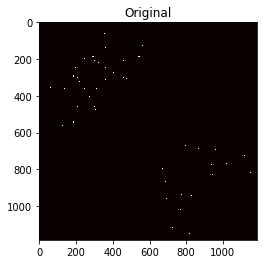

torch.Size([1186, 1186])


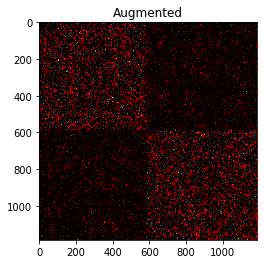

In [115]:
final_adj_matrix = tg.utils.to_dense_adj(edge_idx_final).squeeze(0)
print (final_adj_matrix.shape)

plt.imshow(final_adj_matrix.numpy(), cmap="hot", interpolation="nearest")
plt.title("Original")
plt.show()

# -------------------------------------------------------

final_adj_matrix_syn = tg.utils.to_dense_adj(data.edge_index).squeeze(0)
print (final_adj_matrix_syn.shape)

plt.imshow(final_adj_matrix_syn.numpy(), cmap="hot", interpolation="nearest")
plt.title("Augmented")
plt.show()

In [ ]:
print ("effective p:", p)

p_avg = final_adj_matrix_syn[:x0.size(0), :x0.size(0)].mean()
print ("average p:", p_avg.item() * 2)

q_avg = final_adj_matrix_syn[x0.size(0):, :x0.size(0)].mean()
print ("average q:", q_avg.item() * 2)

effective p: 0.4999985757623232
average p: 0.4991496801376343
average q: 0.0999203696846962


torch.Size([2, 10556])
2708


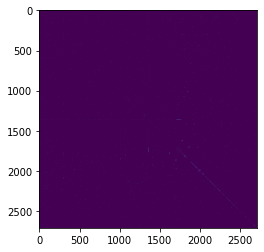

2708


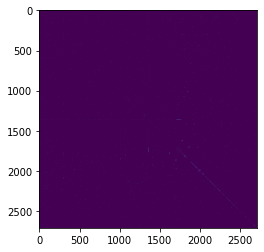

2708


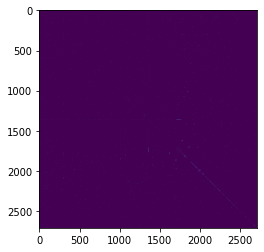

2708


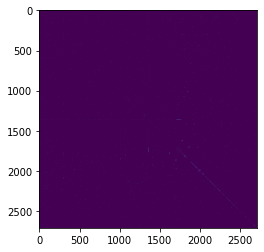

2708


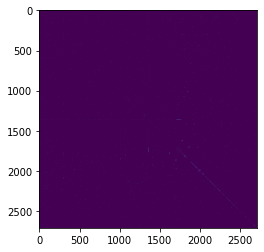

2708


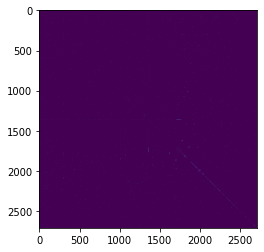

2708


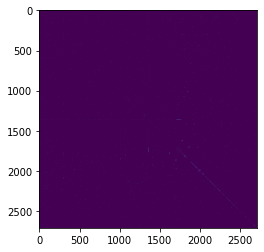

In [58]:
# datasets = [Planetoid(root='data/CiteSeer/', name='CiteSeer'), Planetoid(root='data/Cora/', name='Cora'),Planetoid(root='data/PubMed/', name='PubMed')]

def get_graph_stats(edge_idx, y, x0, x1):
    new_edge_idx = edge_idx.T
    np = 0
    nq = 0
    for idx, pair in enumerate(new_edge_idx):
        i, j = pair
        if y[i] == y[j]:
            np += 1
        else:
            nq += 1
    
    total_intra = math.comb(x0.size(0), 2) + math.comb(x1.size(0), 2)
    total_inter = (x0.size(0) * x1.size(0))
    
    p = np/total_intra
    q = nq/total_inter
        
    return p, q, np, nq

dataset = Planetoid(root='data/Cora/', name='Cora')

data = dataset[0].to(device)
n_classes = data.y.max() + 1
n = data.y.shape[0]
data.x_backup = copy.deepcopy(data.x) 
degree = tg.utils.degree(data.edge_index[1], n)

print (data.edge_index.shape)

all_details = {}

for which_class in range(n_classes):
    c0 = which_class
    
    # y0 = data.y[data.y == c0]
    # y1 = data.y[data.y != c0]
    # y_final = torch.cat([y0, y1])
    # y_final[y_final == c0] = 0
    # y_final[y_final != c0] = 1
    # n_nodes = y0.size(0) + y1.size(0)
    
    y_final = torch.zeros(n, dtype=torch.float64)
    idx = data.y == c0
    y_final[idx] = 1

    x0 = data.x[data.y == c0]
    x1 = data.x[data.y != c0]
    x_final = torch.cat([x0, x1])

    adj = tg.utils.to_dense_adj(data.edge_index).squeeze(0)
    print (adj.size(0))
    
    p, q, np, nq = get_graph_stats(data.edge_index, y_final, x0, x1)
    
    all_details[c0] = {
        "class": c0,
        "p": p,
        "q": q,
        "intra": np,
        "inter": nq,
        "c0 size": x0.size(0),
        "c1 size": x1.size(0),
        "n_edges": int(data.edge_index.size(1))
    }
    
    plt.imshow(adj.numpy())
    plt.show()

In [59]:
from pprint import pprint

pprint (all_details)

{0: {'c0 size': 351,
     'c1 size': 2357,
     'class': 0,
     'inter': 918,
     'intra': 9638,
     'n_edges': 10556,
     'p': 0.0033960882616489033,
     'q': 0.0011096243595182926},
 1: {'c0 size': 217,
     'c1 size': 2491,
     'class': 1,
     'inter': 422,
     'intra': 10134,
     'n_edges': 10556,
     'p': 0.003243159171141452,
     'q': 0.0007806906707464846},
 2: {'c0 size': 418,
     'c1 size': 2290,
     'class': 2,
     'inter': 344,
     'intra': 10212,
     'n_edges': 10556,
     'p': 0.003770967977790727,
     'q': 0.00035937402060132466},
 3: {'c0 size': 818,
     'c1 size': 1890,
     'class': 3,
     'inter': 976,
     'intra': 9580,
     'n_edges': 10556,
     'p': 0.004520450082057022,
     'q': 0.0006312984308094332},
 4: {'c0 size': 426,
     'c1 size': 2282,
     'class': 4,
     'inter': 544,
     'intra': 10012,
     'n_edges': 10556,
     'p': 0.0037175853072948886,
     'q': 0.0005595947875391407},
 5: {'c0 size': 298,
     'c1 size': 2410,
     'class

In [60]:
import json

with open('cora_class_stats.json', 'w') as f:
    json.dump(all_details, f)